In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import math
import os

In [39]:
from colors import *
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(18, 7), "xtick.bottom": True, "grid.linestyle": ":"})

In [40]:
COLOR_DARK_BLUE = '#18206F'
COLOR_MEDIUMDARK_BLUE = '#3661AB'
COLOR_MEDIUMLIGHT_BLUE = '#5CABFF'
COLOR_LIGHT_BLUE = '#0FDFFF'

COLOR_DARK_GREEN = '#416224'
COLOR_MEDIUMDARK_GREEN = '#4FB800'
COLOR_MEDIUMLIGHT_GREEN = '#AEA700'
COLOR_LIGHT_GREEN = '#CDD30F'

COLOR_GLUTROT = '#DA3C43'
COLOR_DARK_RED = '#EC6200'
COLOR_MEDIUM_RED = '#ff8f1c'
COLOR_LIGHT_RED = '#ffb412'

HEIDENELKE_1 = '#9c004b'
HEIDENELKE_2 = '#cc0063'
HEIDENELKE_3 = '#f50076'
HEIDENELKE_4 = '#ff3396'
PALETTE_HEIDENELKE = [HEIDENELKE_1, HEIDENELKE_2, HEIDENELKE_3, HEIDENELKE_4]

PALETTE_REDS = [COLOR_GLUTROT, COLOR_DARK_RED, COLOR_MEDIUM_RED, COLOR_LIGHT_RED]
PALETTE_REDS_SIMPLE = [COLOR_GLUTROT]

PALETTE_BLUES = [COLOR_DARK_BLUE, COLOR_MEDIUMDARK_BLUE, COLOR_MEDIUMLIGHT_BLUE, COLOR_LIGHT_BLUE]
PALETTE_BLUES_SIMPLE = [COLOR_DARK_BLUE, COLOR_LIGHT_BLUE]

PALETTE_GREENS = [COLOR_DARK_GREEN, COLOR_MEDIUMDARK_GREEN, COLOR_MEDIUMLIGHT_GREEN, COLOR_LIGHT_GREEN]
PALETTE_MULTI = [COLOR_MEDIUMDARK_BLUE, COLOR_MEDIUMDARK_GREEN, COLOR_GLUTROT, HEIDENELKE_1]

PALETTE_THREE = [COLOR_DARK_BLUE, COLOR_MEDIUMDARK_BLUE, COLOR_LIGHT_BLUE]

### Preprocessing

In [41]:
PATH = "../data/easteregg_everything_so_far_250"

files = os.listdir(PATH)
files = [x for x in files if 'csv' in x]

In [42]:
file_data = []
diff_means = []
for file in files:
    data_in = pd.read_csv(f"{PATH}/{file}")
    try:
        mean = data_in.query("fw != -1 & diff > 0")['diff'].mean()
        if not math.isnan(mean):
            diff_means.append(mean)
    except:
        print(data_in, file)
    file_data.append(data_in)
    
data = pd.concat(file_data)

In [43]:
data = data[data['framework'] != 'glumpy_sdl']
data = data[data['framework'] != 'glumpy_glfw']
data = data[data['framework'] != 'glumpy_qt5']
data = data[data['framework'] != 'glumpy_pyglet']

In [44]:
nones = data[data['program'] == 'none']
runnings = data[data['program'] != 'none']
runnings_cleaned = runnings[runnings['fw'] != -1]
data = pd.concat([nones, runnings_cleaned])

In [45]:
#TODO: find another way for recignizing whether framework was started/has decorations/another issue occurred
#data = data[data['ete'] > 200]
data = data[data['complexity'] == 'default']

data['ete'] = data['ete'] / 1000
data['fw'] = data['fw'] / 1000
data['diff'] = data['diff'] / 1000

data.loc[data.fw == -0.001, 'fw'] = -1
data.loc[data.program == 'windup_fullscreen', 'program'] = 'windup'
data.loc[data.fullscreen == 'small', 'fullscreen_mode'] = '5.0 - small'

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\123203374.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.0 - small' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data.fullscreen == 'small', 'fullscreen_mode'] = '5.0 - small'


In [46]:
framework_count = data['framework'].nunique()
sqrt = int(math.sqrt(framework_count)) + 1
framework_list = data['framework'].unique()

In [47]:
data

,Unnamed: 0,id,threshold,framework,complexity,framework_complexity,fullscreen,fullscreen_mode,program,ete,fw,diff
0,0,0,515,Direct3D,default,Direct3D_default,fullscreen,NaN,none,8.921,-1.000,8.922
1,1,1,515,Direct3D,default,Direct3D_default,fullscreen,NaN,none,9.818,-1.000,9.819
2,2,2,515,Direct3D,default,Direct3D_default,fullscreen,NaN,none,7.506,-1.000,7.507
3,3,3,515,Direct3D,default,Direct3D_default,fullscreen,NaN,none,8.731,-1.000,8.732
4,4,4,515,Direct3D,default,Direct3D_default,fullscreen,NaN,none,7.077,-1.000,7.078
...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,245,515,wxpython,default,wxpython_default,small,5.0 - small,windup,7.133,4.251,2.882
246,246,246,515,wxpython,default,wxpython_default,small,5.0 - small,windup,6.941,7.088,-0.147
247,247,247,515,wxpython,default,wxpython_default,small,5.0 - small,windup,7.085,4.236,2.849
248,248,248,515,wxpython,default,wxpython_default,small,5.0 - small,windup,7.308,4.364,2.944


# Impact of Window Size and Fullscreen Mode on Framework Latency

Investigating the impact of window size and fullscreen mode, we build three different conditions for the **default test applications**:
- **Fullscreen**: set (exclusive) fullscreen flags whenever possible
- **No Fullscreen**: no fullscreen flag set but window size matches display size
- **Small**: 100x100 pixel window

Not every application allows switching to exclusive fullscreen when setting the fullscreen flag. Some stay in windowed mode, some change the notification state to busy but won't be displayed in exclusive fullscreen.
Thus, we queried the notification state for each application and size condition:
- **Exclusive Fullscreen**: exclusive fullscreen wont allow any interruption
- **Fullscreen**: notification state 'busy'
- **Windowed Full-Size**: full-size window stays in 'windowed' mode
- **Windowed Small**: state for small condition is always 'windowed'

In [48]:
# plot = sns.stripplot(data=data, x='program', y='ete', palette=PALETTE_MULTI, order=['windup', 'getpixel', 'bitblt', 'getdbits', 'none'], size=2)
# plot = sns.boxplot(data=data, x='program', y='ete', palette=PALETTE_MULTI, order=['windup', 'getpixel', 'bitblt', 'getdbits', 'none'])
# plot.set_ylim(0, 35)
# plot.set_title('end to end latency for pixel reader')

### Checking end-to-end latencies
For each of the three resp. four conditions, we checked if a running pixel reader has an impact on end-to-end latency - just to make sure.
Overall, and for each of the frameworks separately.

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\2235622354.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_fs = sns.stripplot(ax=axs[0], data=data[data['fullscreen'] == 'fullscreen'], x='program', y='ete', palette=PALETTE_W_NREUTRAL_RED, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], size=2)
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\2235622354.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_fs = sns.boxplot(ax=axs[0], data=data[data['fullscreen'] == 'fullscreen'], x='program', y='ete', palette=PALETTE_W_NREUTRAL_RED, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'])
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\2235622354.py:9: FutureWarning: 


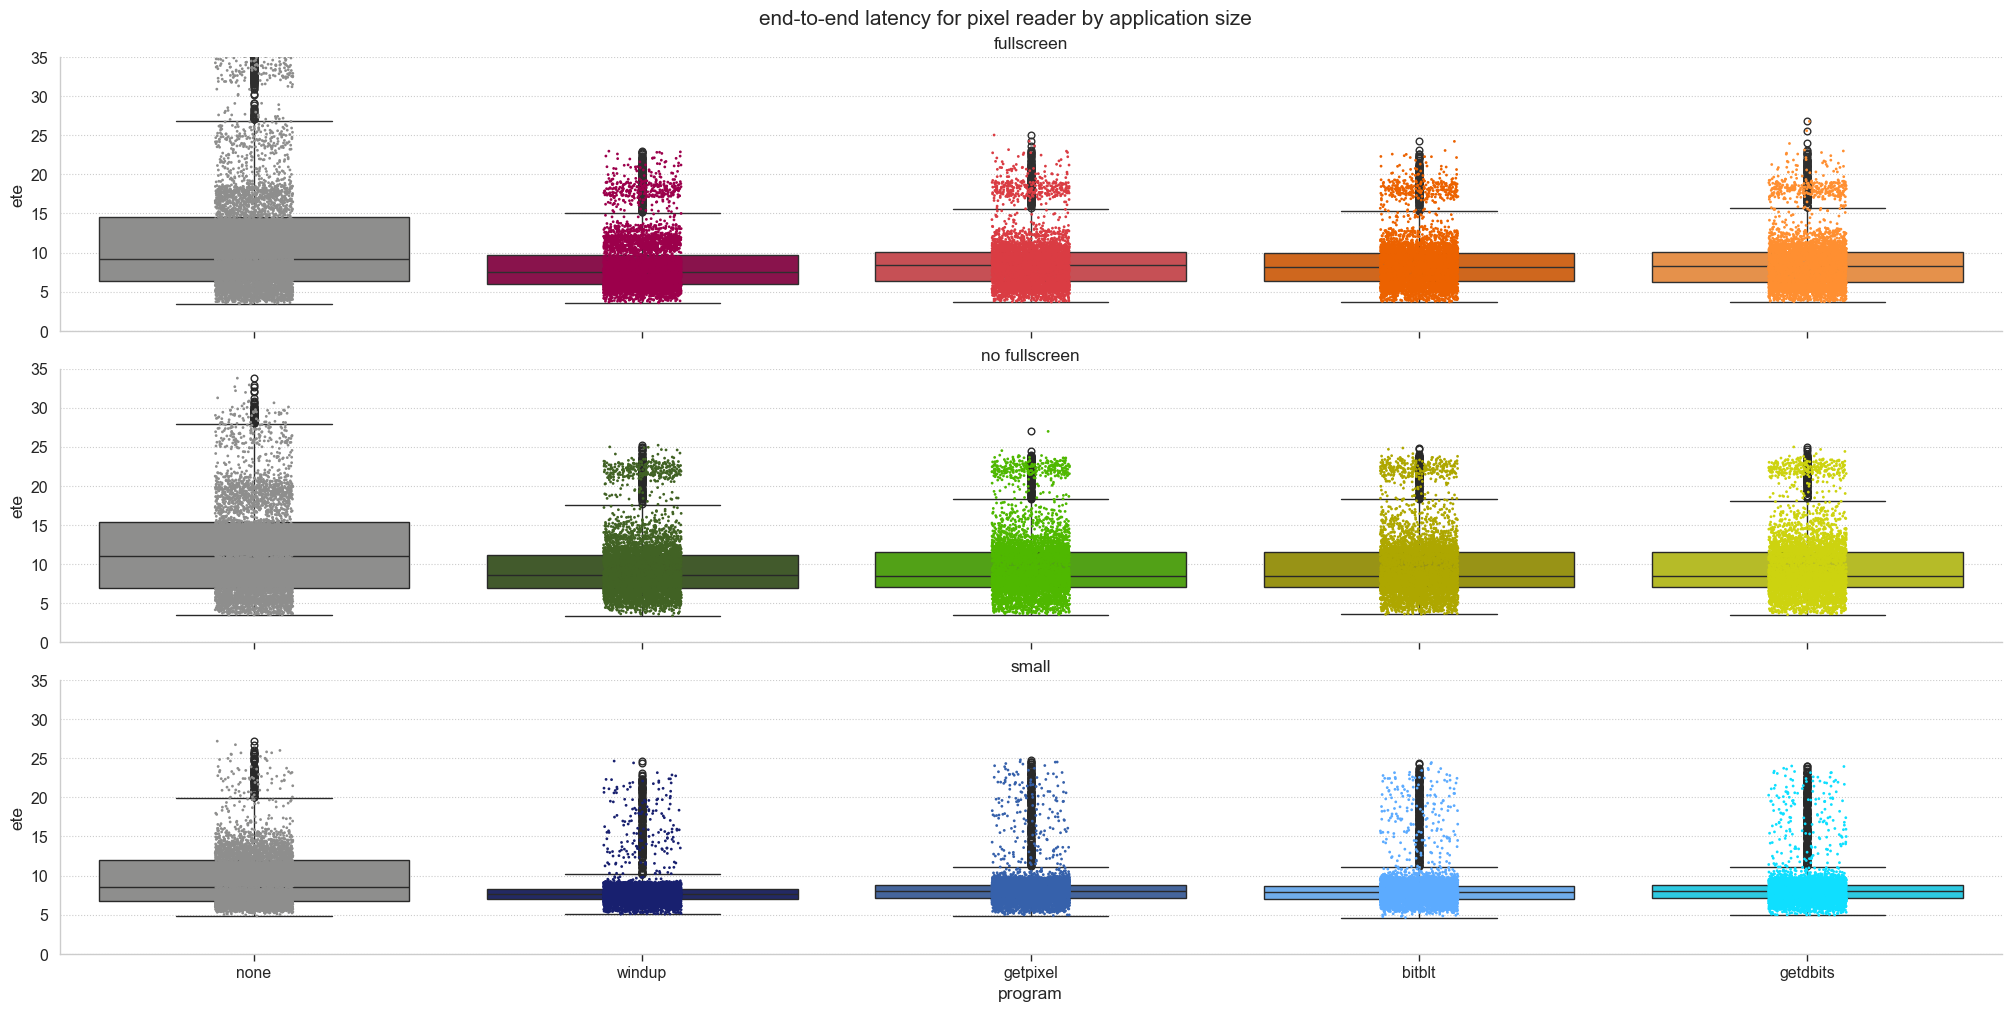

In [49]:
fig, axs = plt.subplots(3, 1, layout='constrained', sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle("end-to-end latency for pixel reader by application size")

plot_fs = sns.stripplot(ax=axs[0], data=data[data['fullscreen'] == 'fullscreen'], x='program', y='ete', palette=PALETTE_W_NREUTRAL_RED, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], size=2)
plot_fs = sns.boxplot(ax=axs[0], data=data[data['fullscreen'] == 'fullscreen'], x='program', y='ete', palette=PALETTE_W_NREUTRAL_RED, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'])
plot_fs.set_ylim(0, 35)
plot_fs.set_title('fullscreen')

plot_nfs = sns.stripplot(ax=axs[1], data=data[data['fullscreen'] == 'no_fullscreen'], x='program', y='ete', palette=PALETTE_W_NREUTRAL_GREEN, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], size=2)
plot_nfs = sns.boxplot(ax=axs[1], data=data[data['fullscreen'] == 'no_fullscreen'], x='program', y='ete', palette=PALETTE_W_NREUTRAL_GREEN, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'])
plot_nfs.set_ylim(0, 35)
plot_nfs.set_title('no fullscreen')

plot_small = sns.stripplot(ax=axs[2], data=data[data['fullscreen'] == 'small'], x='program', y='ete', palette=PALETTE_W_NREUTRAL_BLUE, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], size=2)
plot_small = sns.boxplot(ax=axs[2], data=data[data['fullscreen'] == 'small'], x='program', y='ete', palette=PALETTE_W_NREUTRAL_BLUE, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'])
plot_small.set_ylim(0, 35)
plot_small.set_title('small')

sns.despine(bottom = False, left = False)

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\1529327492.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_fs = sns.stripplot(ax=axs[0], data=data[data['fullscreen_mode'] == 3.0], x='program', y='ete', palette=PALETTE_W_NREUTRAL_RED, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], size=2)
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\1529327492.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_fs = sns.boxplot(ax=axs[0], data=data[data['fullscreen_mode'] == 3.0], x='program', y='ete', palette=PALETTE_W_NREUTRAL_RED, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'])
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\1529327492.py:9: FutureWarning: 

Passing

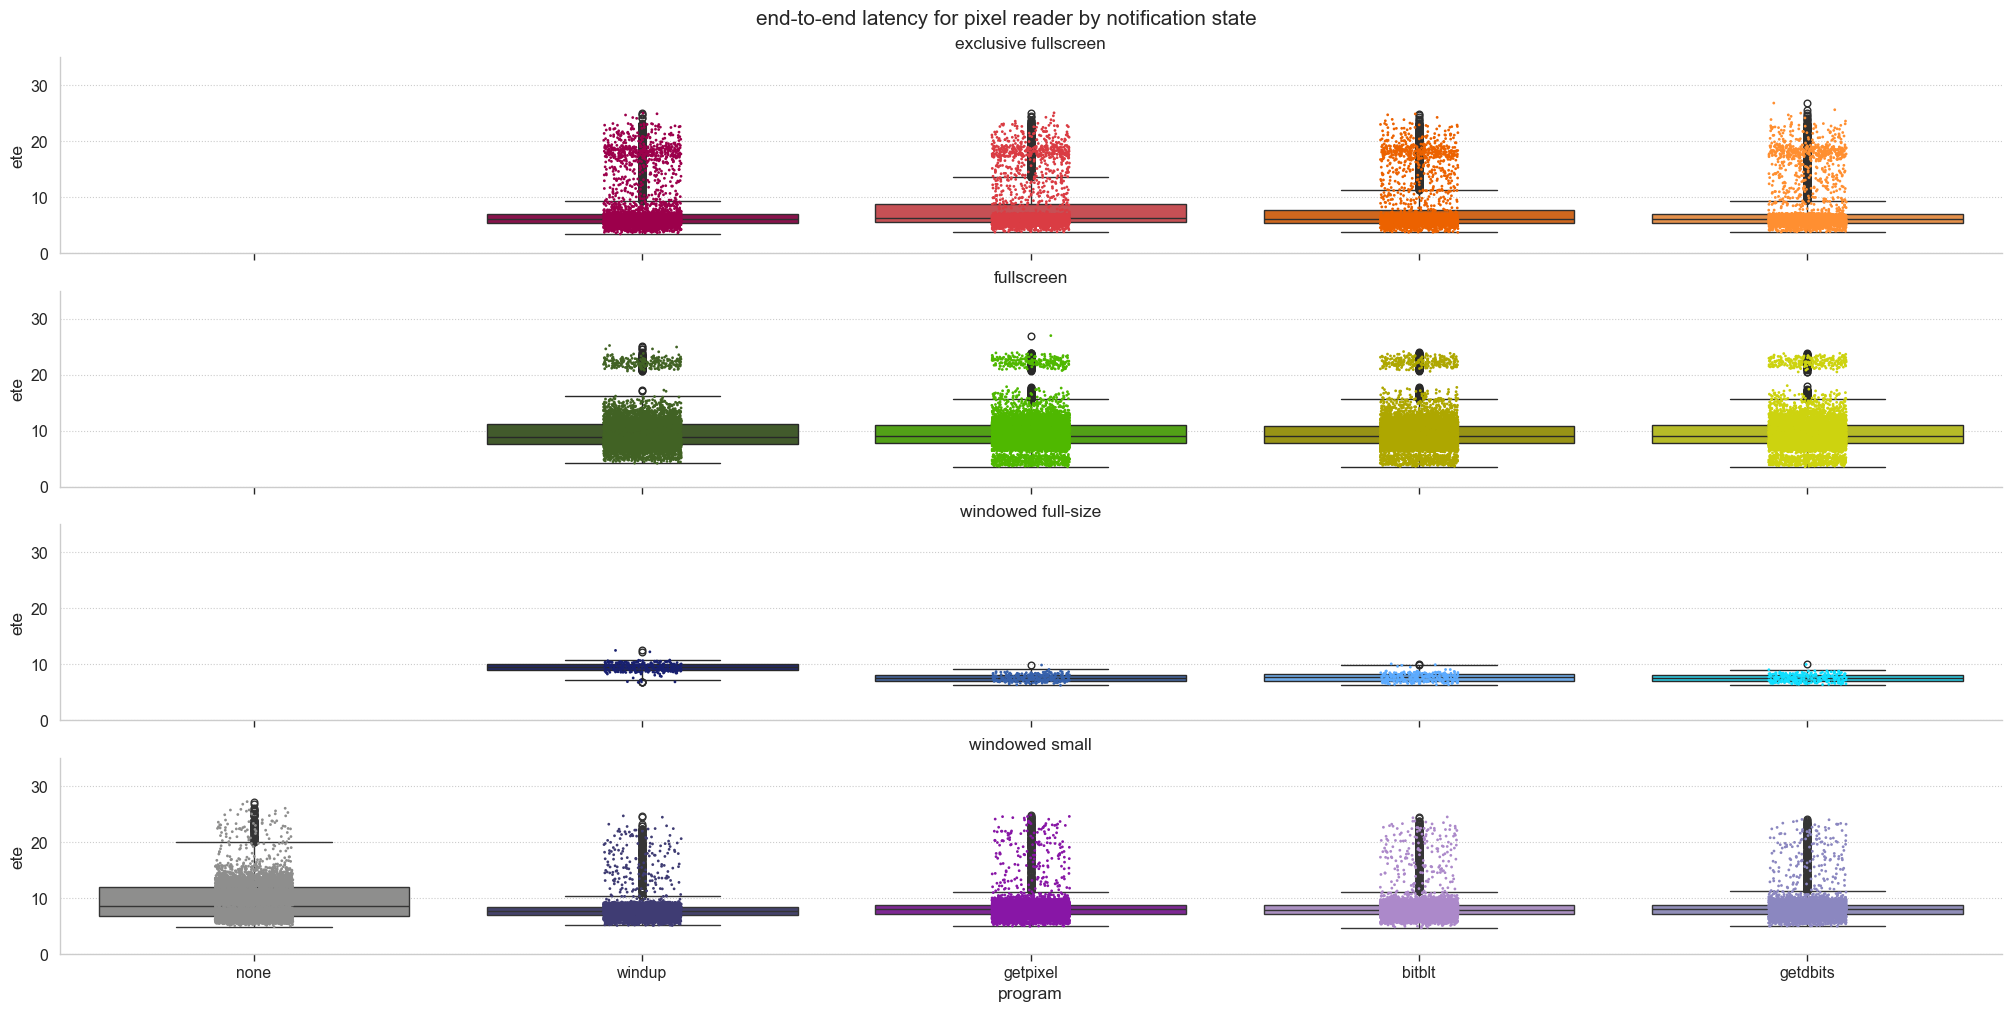

In [50]:
fig, axs = plt.subplots(4, 1, layout='constrained', sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle("end-to-end latency for pixel reader by notification state")

plot_fs = sns.stripplot(ax=axs[0], data=data[data['fullscreen_mode'] == 3.0], x='program', y='ete', palette=PALETTE_W_NREUTRAL_RED, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], size=2)
plot_fs = sns.boxplot(ax=axs[0], data=data[data['fullscreen_mode'] == 3.0], x='program', y='ete', palette=PALETTE_W_NREUTRAL_RED, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'])
plot_fs.set_ylim(0, 35)
plot_fs.set_title('exclusive fullscreen')

plot_nfs = sns.stripplot(ax=axs[1], data=data[data['fullscreen_mode'] == 2.0], x='program', y='ete', palette=PALETTE_W_NREUTRAL_GREEN, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], size=2)
plot_nfs = sns.boxplot(ax=axs[1], data=data[data['fullscreen_mode'] == 2.0], x='program', y='ete', palette=PALETTE_W_NREUTRAL_GREEN, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'])
plot_nfs.set_ylim(0, 35)
plot_nfs.set_title('fullscreen')

plot_small = sns.stripplot(ax=axs[2], data=data[data['fullscreen_mode'] == 5.0], x='program', y='ete', palette=PALETTE_W_NREUTRAL_BLUE, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], size=2)
plot_small = sns.boxplot(ax=axs[2], data=data[data['fullscreen_mode'] == 5.0], x='program', y='ete', palette=PALETTE_W_NREUTRAL_BLUE, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'])
plot_small.set_ylim(0, 35)
plot_small.set_title('windowed full-size')

plot_small = sns.stripplot(ax=axs[3], data=data[data['fullscreen_mode'] == '5.0 - small'], x='program', y='ete', palette=PALETTE_W_NREUTRAL_VIOLET, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], size=2)
plot_small = sns.boxplot(ax=axs[3], data=data[data['fullscreen_mode'] == '5.0 - small'], x='program', y='ete', palette=PALETTE_W_NREUTRAL_VIOLET, order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'])
plot_small.set_ylim(0, 35)
plot_small.set_title('windowed small')

sns.despine(bottom = False, left = False)

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\3822256661.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)


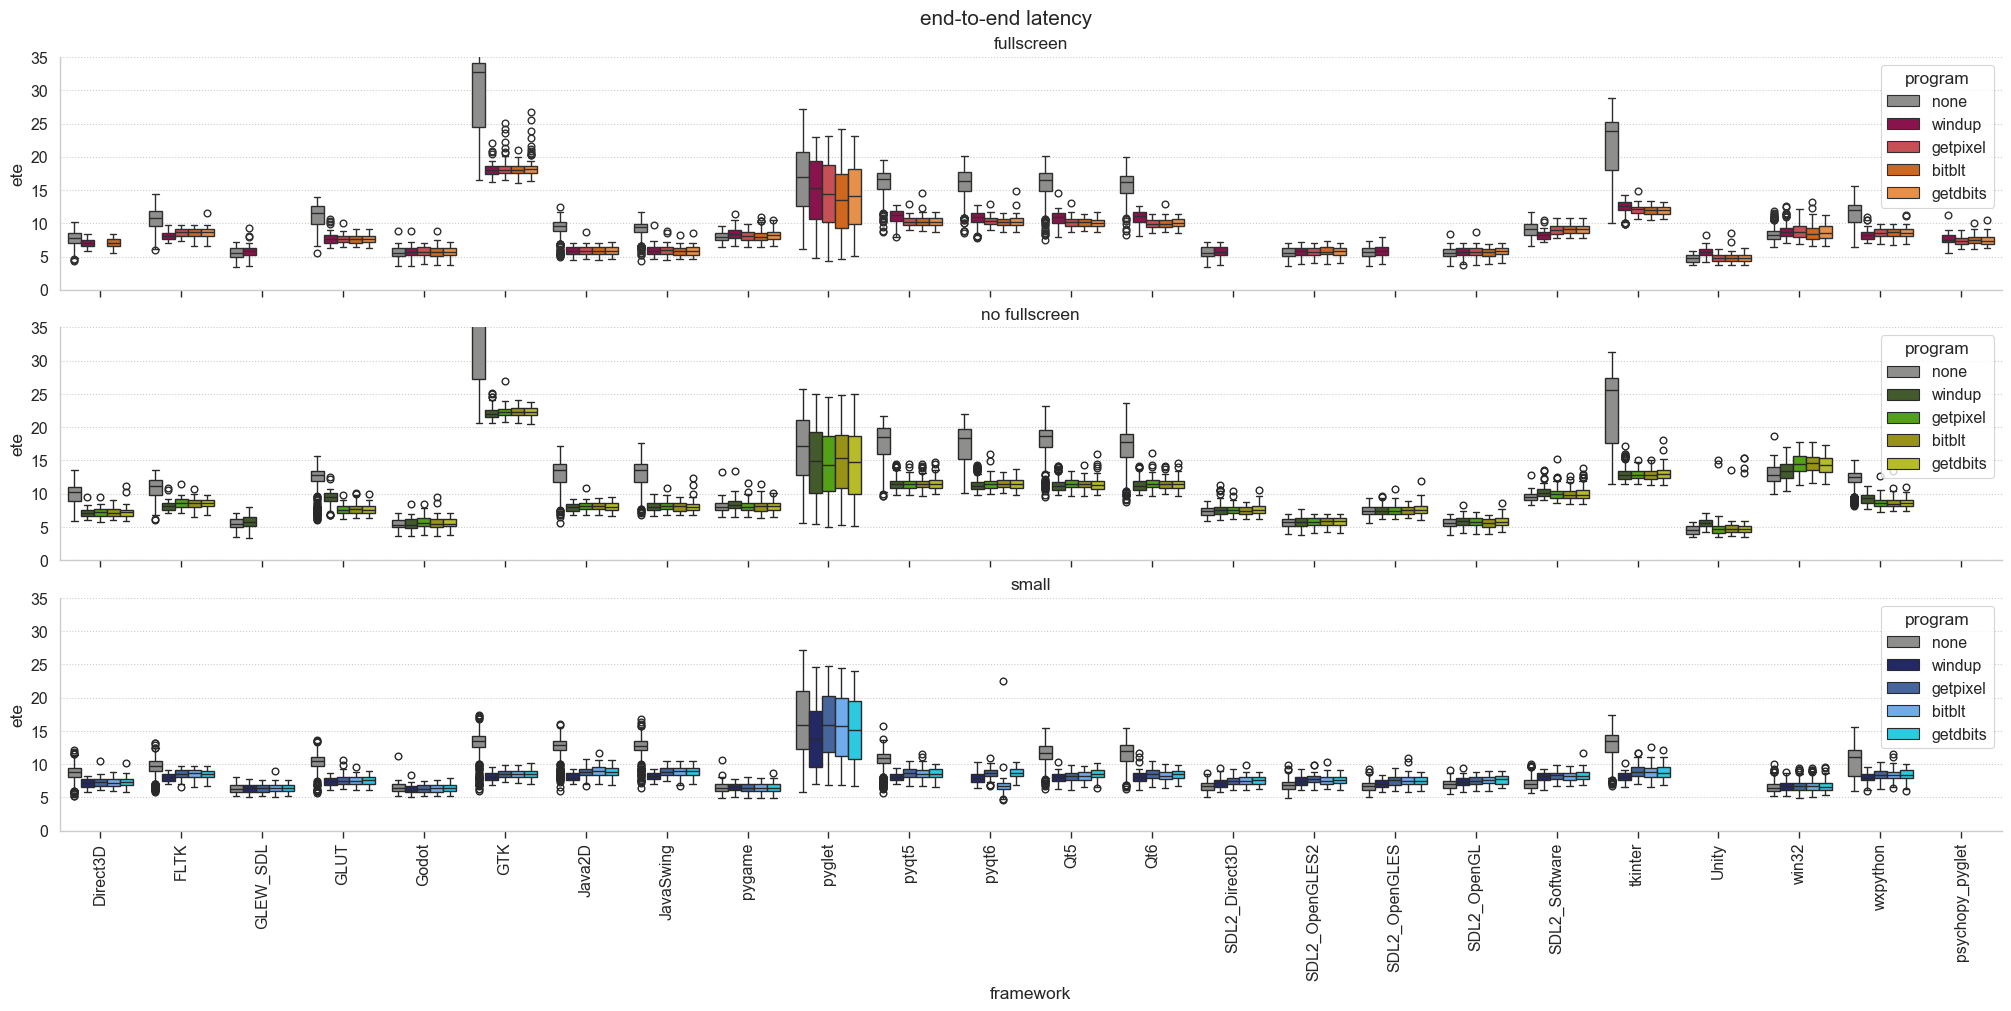

In [51]:
fig, axs = plt.subplots(3, 1, layout='constrained', sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle("end-to-end latency")

plot_fs = sns.boxplot(ax=axs[0], data=data[data['fullscreen'] == 'fullscreen'], x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_RED)
plot_fs.set_title('fullscreen')

plot_nfs = sns.boxplot(ax=axs[1], data=data[data['fullscreen'] == 'no_fullscreen'], x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_GREEN)
plot_nfs.set_title('no fullscreen')

plot_small = sns.boxplot(ax=axs[2], data=data[data['fullscreen'] == 'small'], x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_BLUE)
plot_small.set_title('small')

axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)
axs[2].set_ylim(0, 35)

sns.despine(bottom = False, left = False)

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\2802538820.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=90)


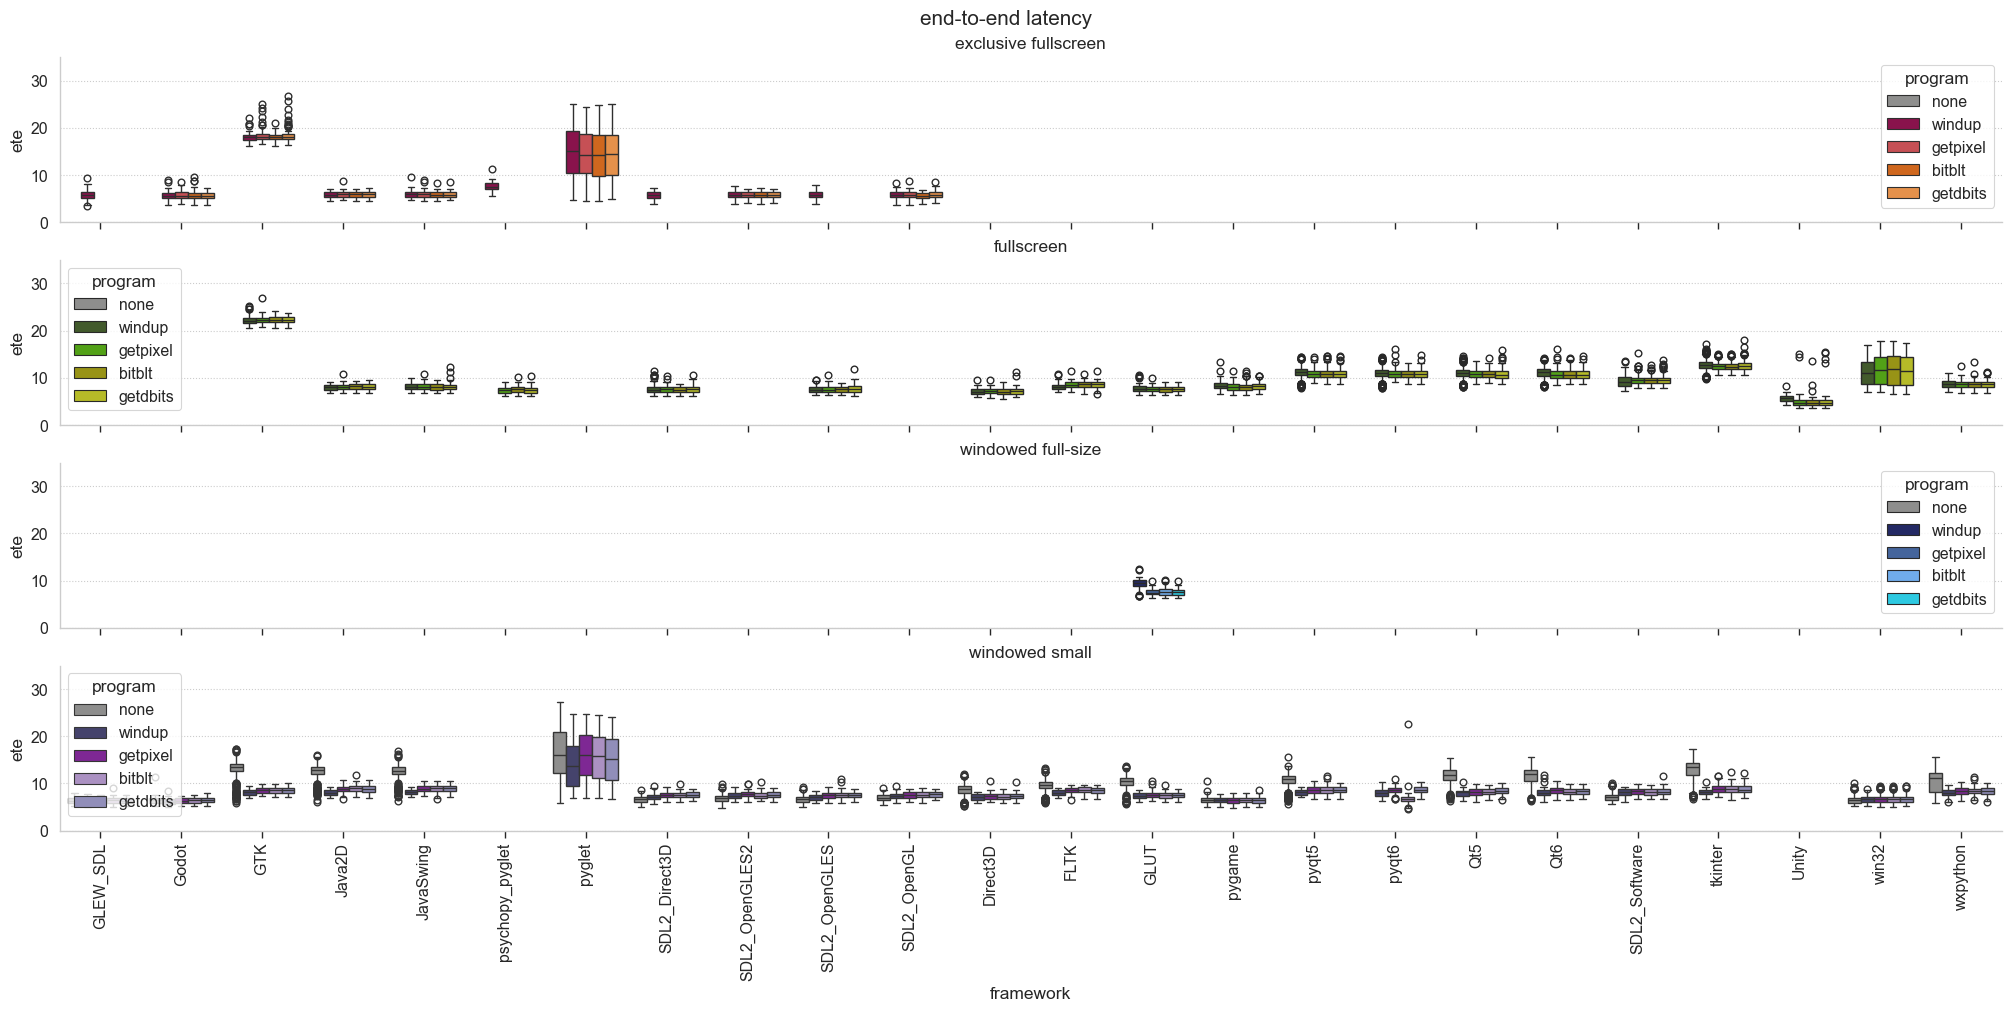

In [52]:
fig, axs = plt.subplots(4, 1, layout='constrained', sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle("end-to-end latency")

plot_fs = sns.boxplot(ax=axs[0], data=data[data['fullscreen_mode'] == 3.0], x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_RED)
plot_fs.set_title('exclusive fullscreen')

plot_nfs = sns.boxplot(ax=axs[1], data=data[data['fullscreen_mode'] == 2.0], x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_GREEN)
plot_nfs.set_title('fullscreen')

plot_nfs = sns.boxplot(ax=axs[2], data=data[data['fullscreen_mode'] == 5.0], x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_BLUE)
plot_nfs.set_title('windowed full-size')

plot_small = sns.boxplot(ax=axs[3], data=data[data['fullscreen_mode'] == '5.0 - small'], x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_VIOLET)
plot_small.set_title('windowed small')

axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=90)
axs[3].set_ylim(0, 35)

sns.despine(bottom = False, left = False)

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\1946220718.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)


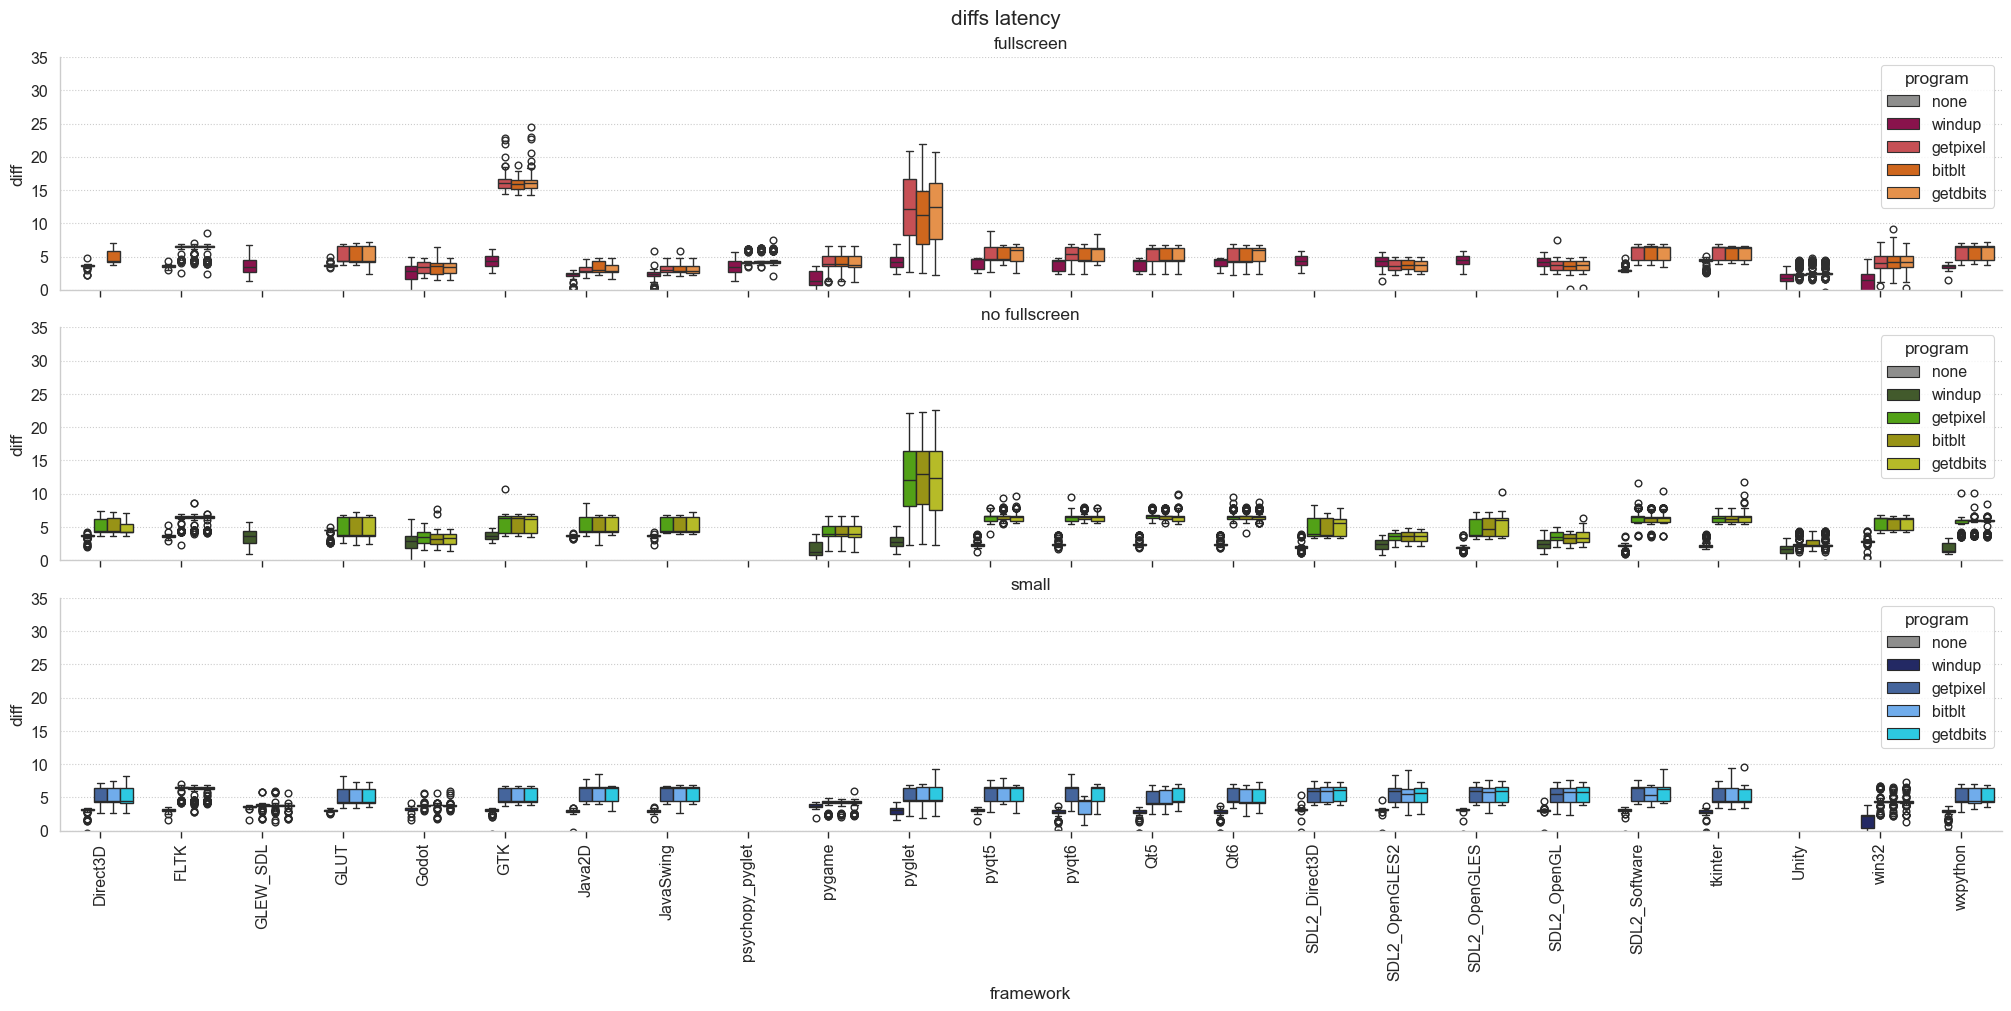

In [53]:
fig, axs = plt.subplots(3, 1, layout='constrained', sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle("diffs latency")

data_temp = data[data['program'] != 'none']
plot_fs = sns.boxplot(ax=axs[0], data=data_temp[data_temp['fullscreen'] == 'fullscreen'], x='framework', y='diff', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_RED)
plot_fs.set_title('fullscreen')

plot_nfs = sns.boxplot(ax=axs[1], data=data_temp[data_temp['fullscreen'] == 'no_fullscreen'], x='framework', y='diff', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_GREEN)
plot_nfs.set_title('no fullscreen')

plot_small = sns.boxplot(ax=axs[2], data=data_temp[data_temp['fullscreen'] == 'small'], x='framework', y='diff', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_BLUE)
plot_small.set_title('small')

axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)
axs[2].set_ylim(0, 35)

sns.despine(bottom = False, left = False)

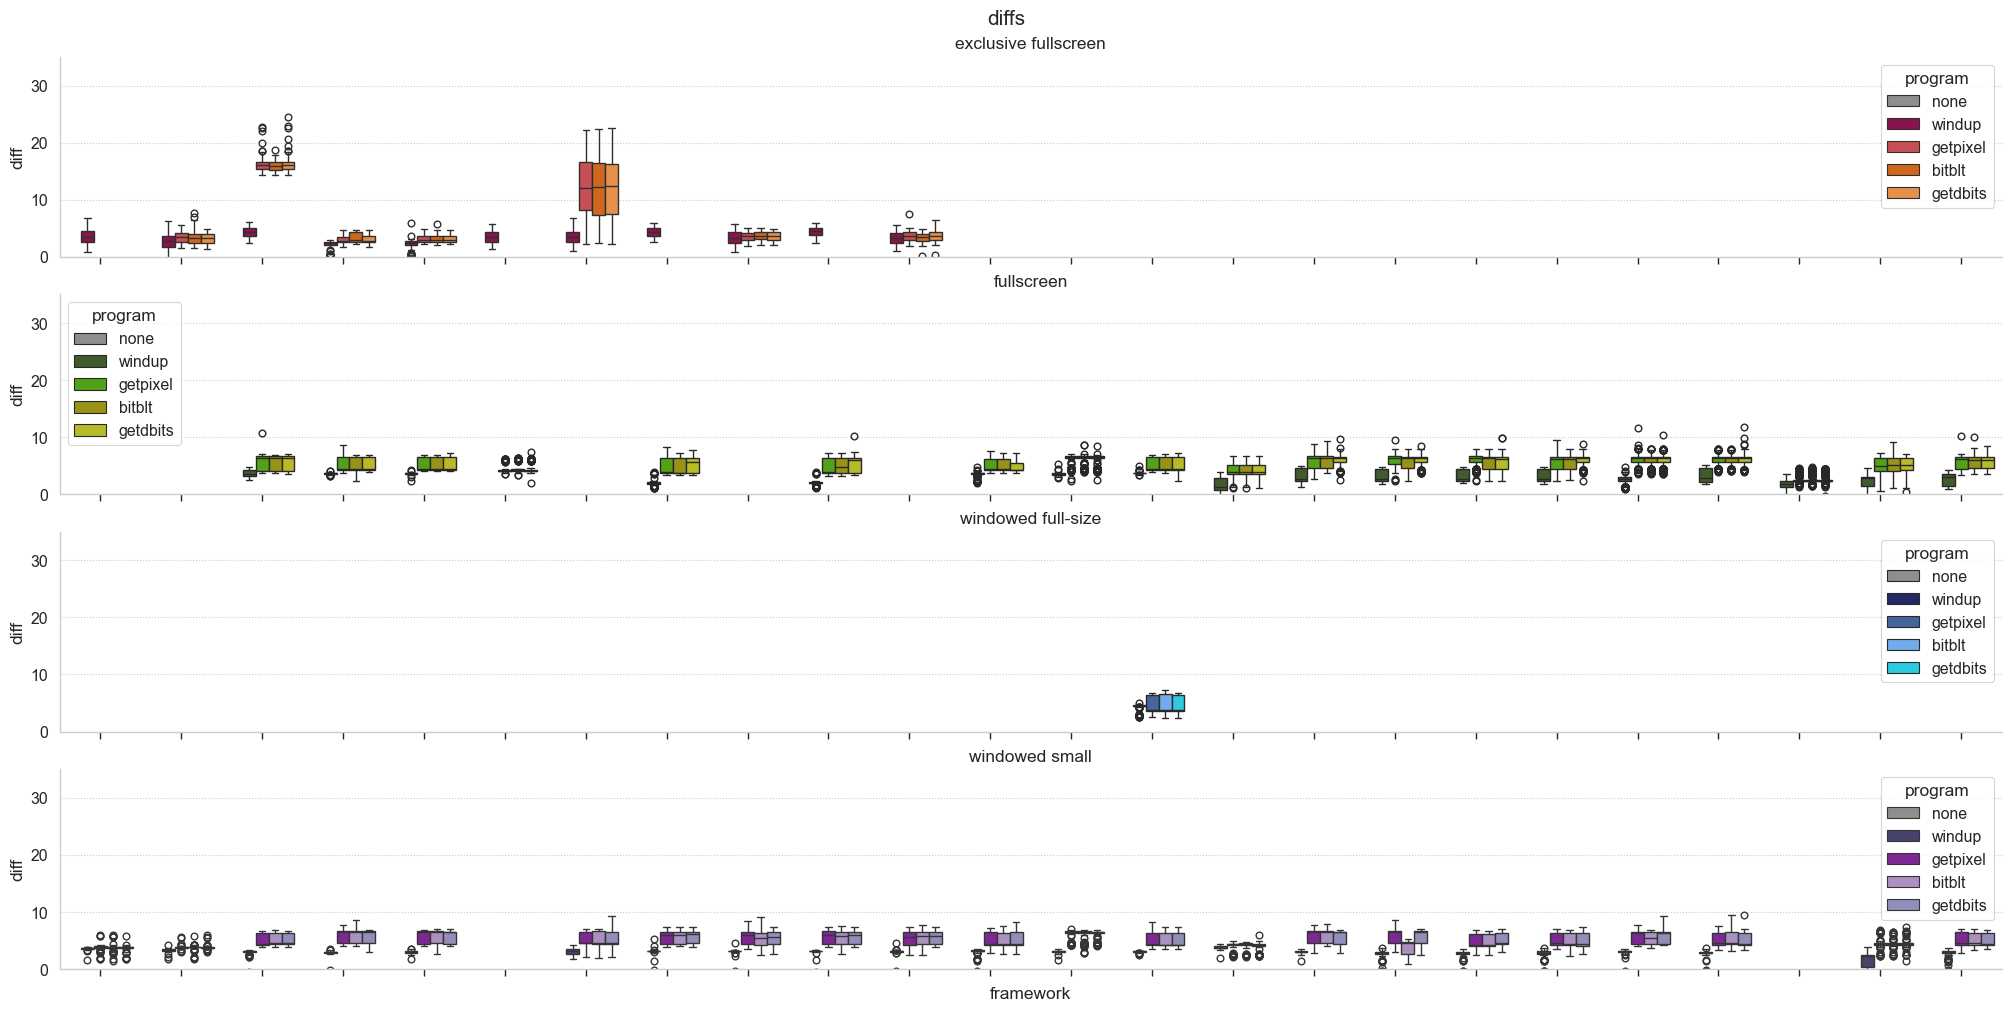

In [54]:
fig, axs = plt.subplots(4, 1, layout='constrained', sharex=True, sharey=True, figsize=(20, 10))
fig.suptitle("diffs")

plot_fs = sns.boxplot(ax=axs[0], data=data_temp[data_temp['fullscreen_mode'] == 3.0], x='framework', y='diff', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_RED)
plot_fs.set_title('exclusive fullscreen')

plot_nfs = sns.boxplot(ax=axs[1], data=data_temp[data_temp['fullscreen_mode'] == 2.0], x='framework', y='diff', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_GREEN)
plot_nfs.set_title('fullscreen')

plot_nfs = sns.boxplot(ax=axs[2], data=data_temp[data_temp['fullscreen_mode'] == 5.0], x='framework', y='diff', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_BLUE)
plot_nfs.set_title('windowed full-size')

plot_small = sns.boxplot(ax=axs[3], data=data_temp[data_temp['fullscreen_mode'] == '5.0 - small'], x='framework', y='diff', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_W_NREUTRAL_VIOLET)
plot_small.set_title('windowed small')

axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)
axs[2].set_ylim(0, 35)

sns.despine(bottom = False, left = False)

# Framework Latency
For each of the three resp. four conditions, we measured framework latencies.

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\3424274581.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[x, y], data=data_temp[data_temp['framework'] == framework], x='fullscreen', y='fw', palette=[HEIDENELKE_1, COLOR_GLUTROT])
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\3424274581.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[x, y], data=data_temp[data_temp['framework'] == framework], x='fullscreen', y='fw', palette=[HEIDENELKE_1, COLOR_GLUTROT])
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_37548\3424274581.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` varia

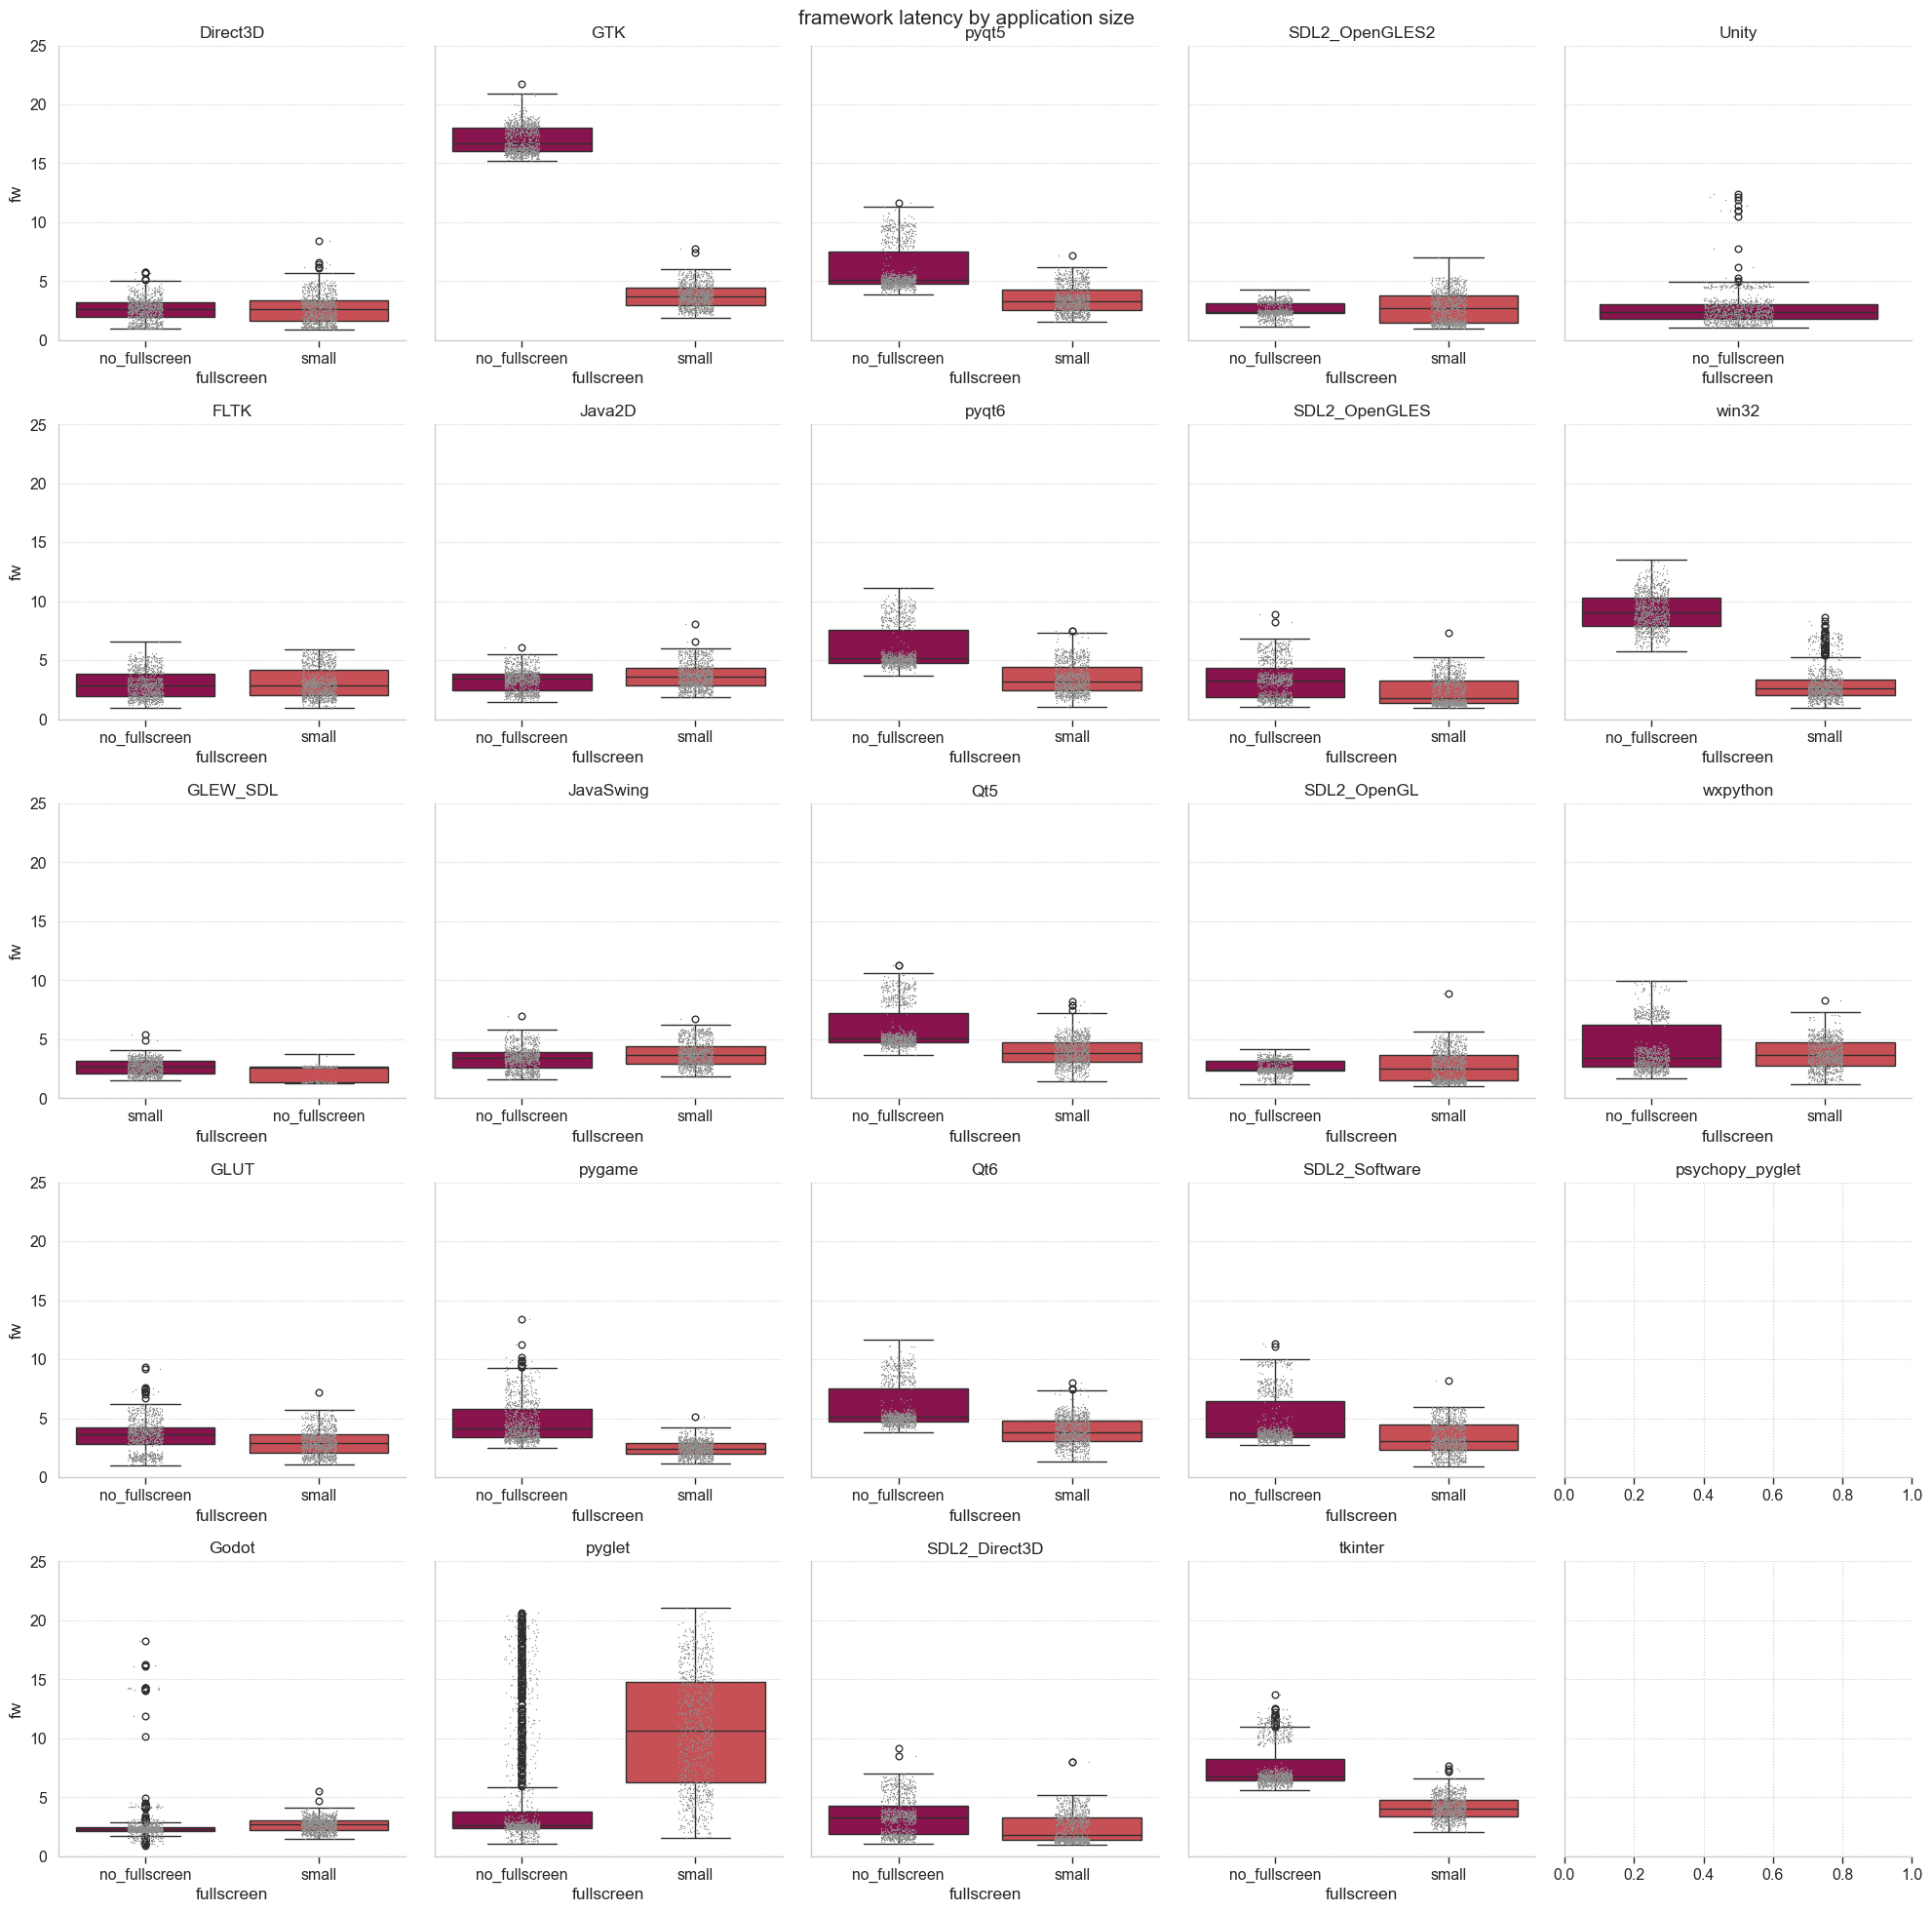

In [55]:
fig, axes = plt.subplots(sqrt, sqrt, figsize=(20, 20), sharey=True)
fig.suptitle("framework latency by application size")

data_temp = data[data['program'] != 'none']
data_temp = data_temp[data_temp['fullscreen'] != 'fullscreen']

x = y = 0
for i, framework in enumerate(framework_list):
    x = i % sqrt
    y = y + 1 if (i != 0 and i % sqrt == 0) else y
    sns.boxplot(ax=axes[x, y], data=data_temp[data_temp['framework'] == framework], x='fullscreen', y='fw', palette=[HEIDENELKE_1, COLOR_GLUTROT])
    sns.stripplot(ax=axes[x, y], data=data_temp[data_temp['framework'] == framework], x='fullscreen', y='fw', size=1, color=COLOR_NONE)
    axes[x, y].set_title(framework)
    axes[x, y].set_ylim(0, 25)

fig.tight_layout()
sns.despine(bottom = False, left = False)

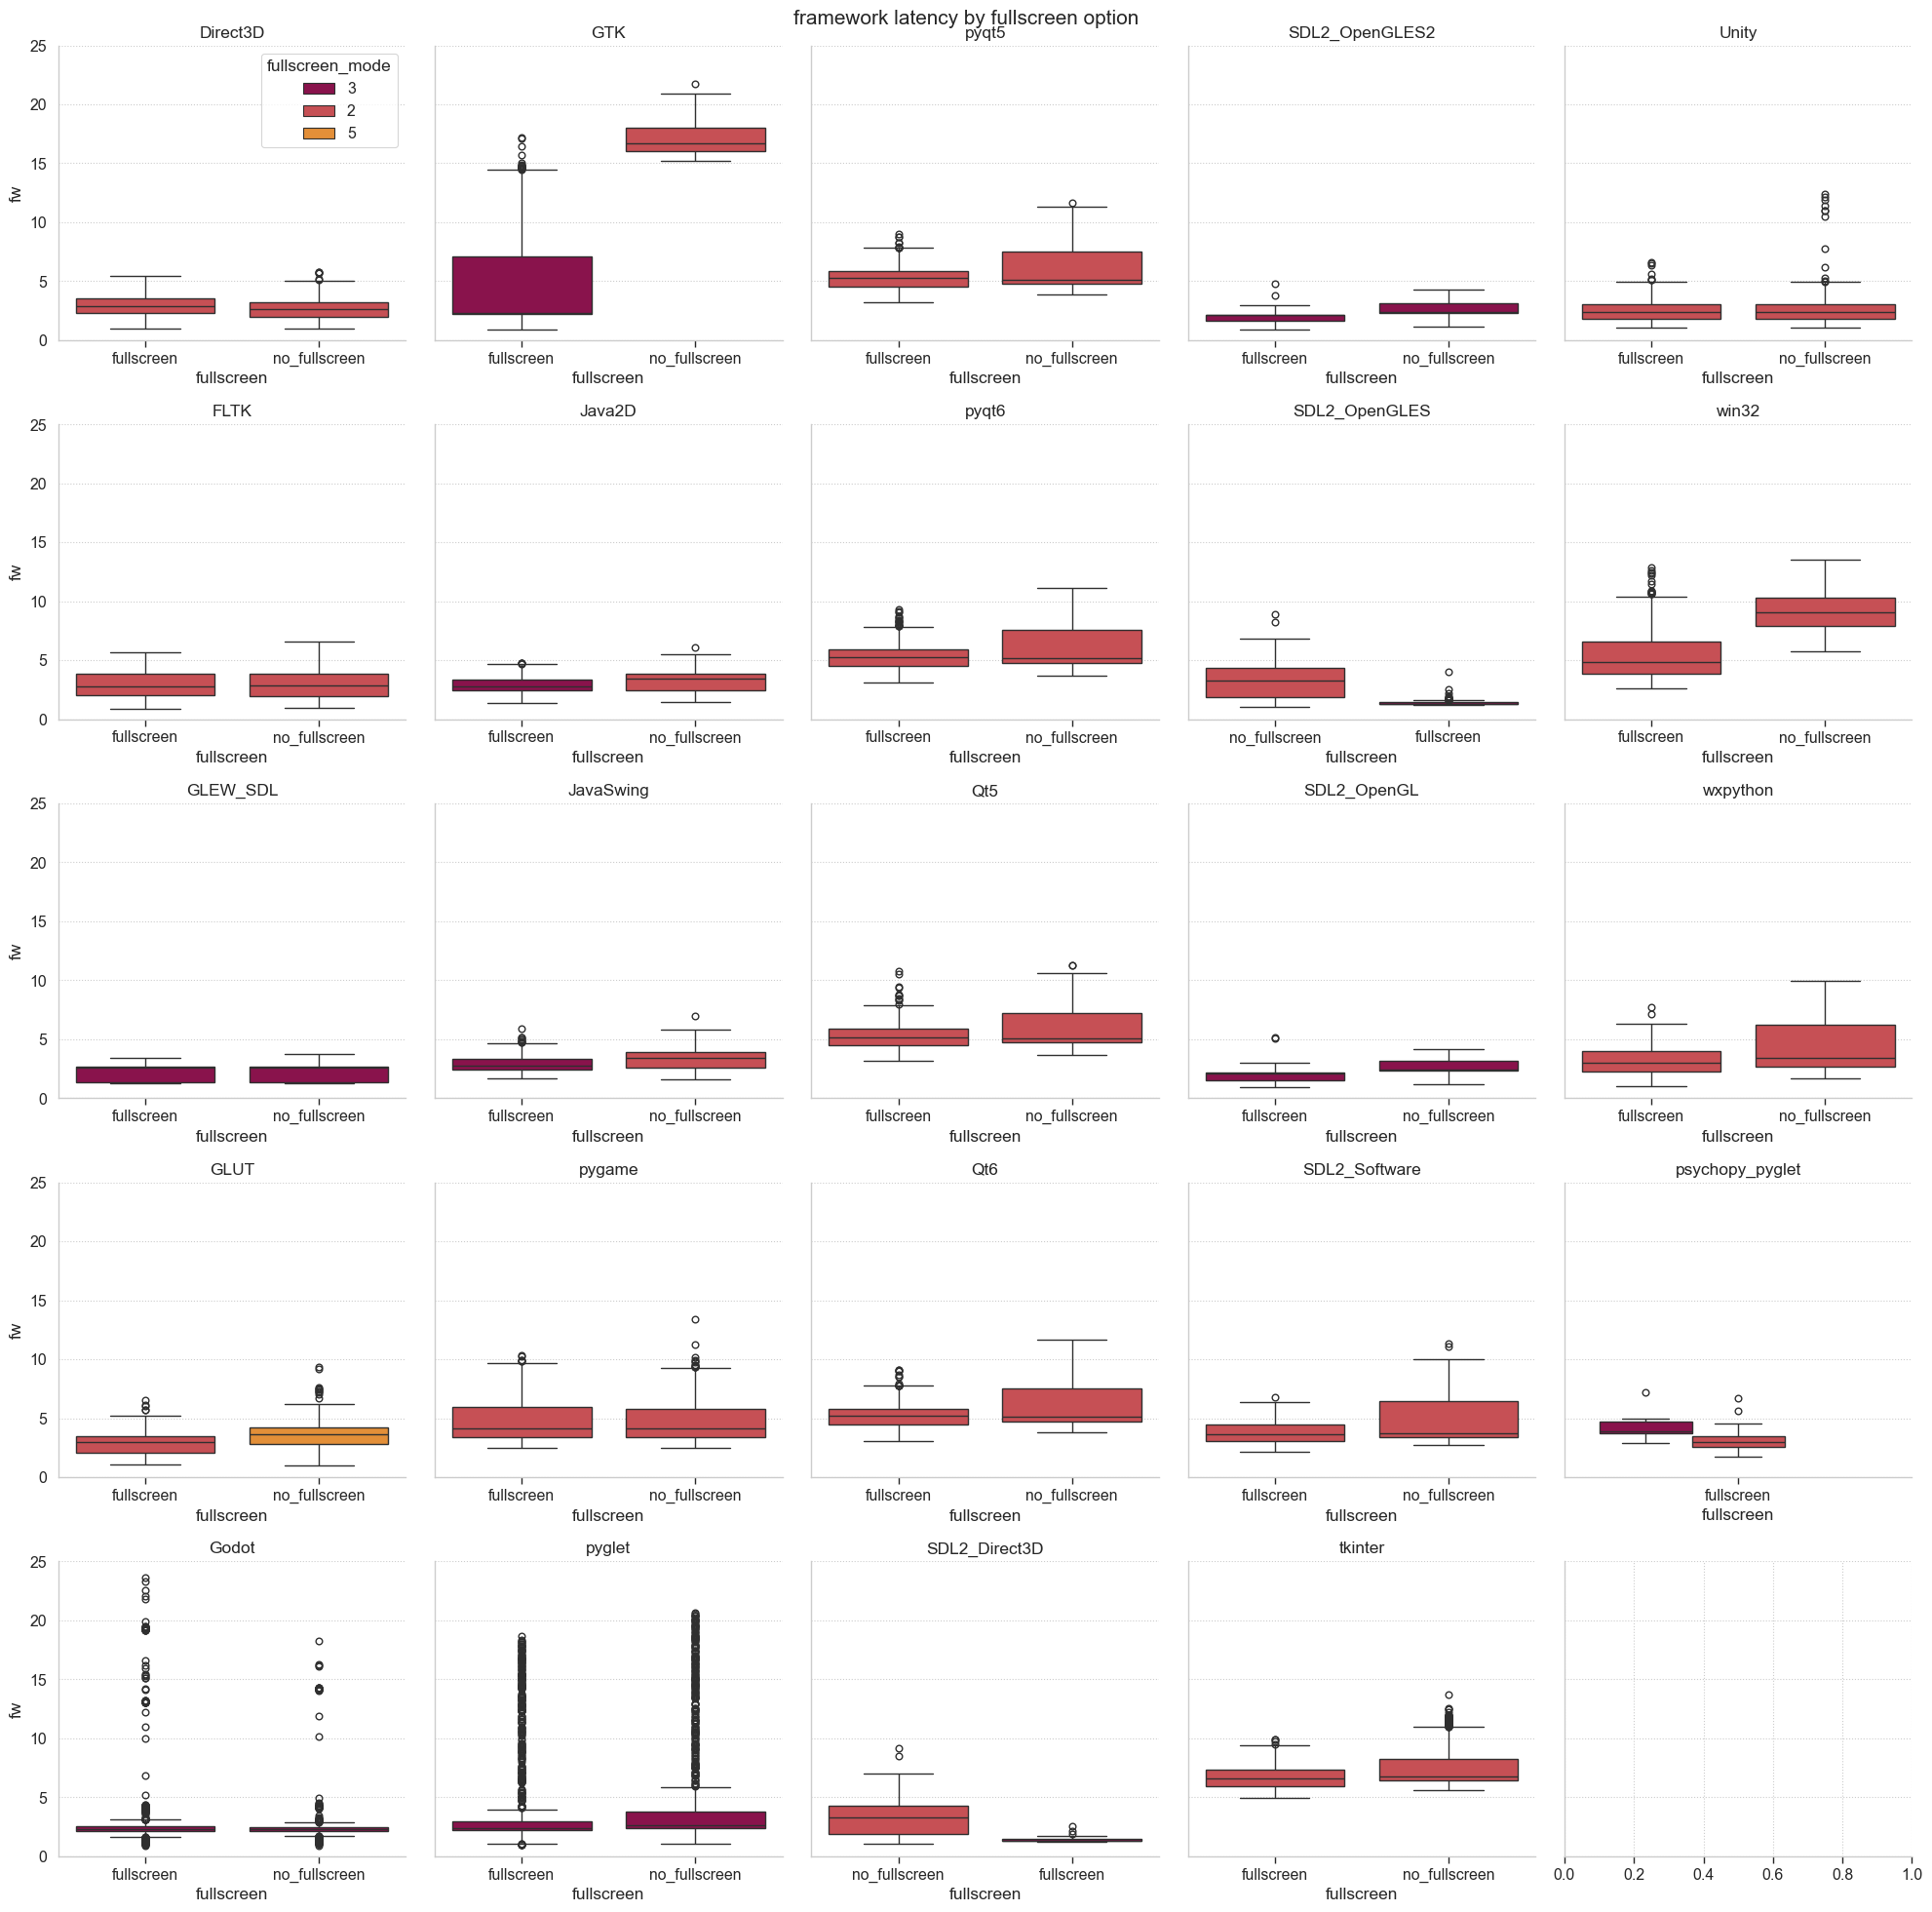

In [56]:
fig, axes = plt.subplots(sqrt, sqrt, figsize=(20, 20), sharey=True)
fig.suptitle("framework latency by fullscreen option")

data_temp = data[data['program'] != 'none']
data_temp = data_temp[data_temp['fullscreen'] != 'small']

x = y = 0
for i, framework in enumerate(framework_list):
    x = i % sqrt
    y = y + 1 if (i != 0 and i % sqrt == 0) else y
    sns.boxplot(ax=axes[x, y], data=data_temp[data_temp['framework'] == framework], x='fullscreen', hue='fullscreen_mode', hue_order=[3, 2, 5], y='fw', palette=[COLOR_HEIDENELKE, COLOR_GLUTROT, COLOR_MEDIUM_RED])
    #sns.stripplot(ax=axes[x, y], data=data_temp[data_temp['framework'] == framework], x='fullscreen', hue='fullscreen_mode', hue_order=[3, 2, 5], y='fw', palette=PALETTE_REDS, size=2)
    axes[x, y].set_title(framework)
    axes[x, y].set_ylim(0, 25)
    axes[x, y].get_legend().set_visible(False)
axes[0, 0].get_legend().set_visible(True)

fig.tight_layout()
sns.despine(bottom = False, left = False)

## Impact of Fullscreen Mode and Window Size on Framework Latencies for each Framework

In [57]:
# fig, axes = plt.subplots(sqrt, sqrt, figsize=(20, 20), sharex=True, sharey=True)
# fig.suptitle("framework latency by application size")

# data_temp = data[data['program'] != 'none']
# x = y = 0
# for i, framework in enumerate(framework_list):
#     x = i % sqrt
#     y = y + 1 if (i != 0 and i % sqrt == 0) else y
#     sns.boxplot(ax=axes[x, y], data=data_temp[data_temp['framework'] == framework], hue='fullscreen', y='fw', hue_order=['fullscreen', 'no_fullscreen', 'small'], palette=PALETTE_FULLSCREEN_OPTIONS)
#     axes[x, y].set_title(framework)
#     axes[x, y].set_ylim(0, 35)
#     #axes[x, y].get_legend().set_visible(False)

# sns.despine(bottom = False, left = False)

## Impact of Notification State and Window Size on Framework Latencies for each Framework

In [58]:
# fig, axes = plt.subplots(sqrt, sqrt, figsize=(20, 20), sharex=True, sharey=True)
# fig.suptitle("framework latency by notification state")

# x = y = 0
# for i, framework in enumerate(framework_list):
#     x = i % sqrt
#     y = y + 1 if (i != 0 and i % sqrt == 0) else y
#     sns.boxplot(ax=axes[x, y], data=data[data['framework'] == framework], hue='fullscreen_mode', y='fw', hue_order=[3.0, 2.0, 5.0, '5.0 - small'], palette=PALETTE_REDS)
#     axes[x, y].set_title(framework)
#     axes[x, y].set_ylim(0, 20)
#     axes[x, y].get_legend().set_visible(False)
# axes[0, 4].get_legend().set_visible(True)

# sns.despine(bottom = False, left = False)

In [59]:
# fig, axs = plt.subplots(3, 1, layout='constrained', sharex=True, sharey=True, figsize=(20, 10))
# fig.suptitle("end-to-end latency")

# plot_fs = sns.stripplot(ax=axs[0], data=data[data['fullscreen'] == True], x='framework', y='ete', hue='program', hue_order=['windup', 'getpixel', 'bitblt', 'getdbits', 'none'], dodge=True, palette=PALETTE_MULTI, size=2)
# plot_fs.set_title('fullscreen')

# plot_nfs = sns.stripplot(ax=axs[1], data=data[data['fullscreen'] == False], x='framework', y='ete', hue='program', hue_order=['windup', 'getpixel', 'bitblt', 'getdbits', 'none'], dodge=True, palette=PALETTE_MULTI, size=2)
# plot_nfs.set_title('no fullscreen')

# plot_small = sns.stripplot(ax=axs[2], data=data[data['fullscreen'] == 'small'], x='framework', y='ete', hue='program', hue_order=['windup', 'getpixel', 'bitblt', 'getdbits', 'none'], dodge=True, palette=PALETTE_MULTI, size=2)
# plot_small.set_title('small')

# axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)
# axs[2].set_ylim(0, 30)

# sns.despine(bottom = False, left = False)

## Impact of Fullscreen Mode and Window Size on Framework Latencies over all Frameworks

In [60]:
# plot = sns.boxplot(data=data[data['program'] != 'none'], x='fullscreen', y='fw', order=[True, False, 'small'], palette=PALETTE_FULLSCREEN_OPTIONS)
# plot.set_ylim(0, 35)
# plot.set_title('framework latency by application size')

## Impact of Notification State and Window Size on Framework Latencies over all Frameworks

In [61]:
# plot = sns.boxplot(data=data[data['program'] != 'none'], x='fullscreen_mode', y='fw', order=[3.0, 2.0, 5.0, '5.0 - small'], palette=PALETTE_FULLSCREEN_MODES)
# labels = plot.get_xticklabels()
# labels[0] = 'exclusive fullscreen'
# labels[1] = 'fullscreen'
# labels[2] = 'windowed full-size'
# labels[3] = 'windowed small'
# plot.set_xticklabels(labels)
# plot.set_ylim(0, 35)
# plot.set_title('framework latency by notification state')

In [62]:
# plot = sns.boxplot(data=data[data['program'] != 'none'], x='fullscreen_mode', y='diff', order=[3.0, 2.0, 5.0, '5.0 - small'], palette=PALETTE_FULLSCREEN_MODES)
# labels = plot.get_xticklabels()
# labels[0] = 'exclusive fullscreen'
# labels[1] = 'fullscreen'
# labels[2] = 'windowed full-size'
# labels[3] = 'windowed small'
# plot.set_xticklabels(labels)
# plot.set_ylim(0, 35)
# plot.set_title('framework latency by notification state')

In [63]:
# plot = sns.stripplot(data=data, x='framework', y='fw', hue='fullscreen_mode', dodge=True, palette=PALETTE_CONTRAST3, hue_order=[3.0, 2.0, 5.0, '5.0 - small'], size=2)

# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
# plot.axes.set_ylim(0, 40)

In [64]:
# plot = sns.stripplot(data=data, x='framework', y='fw', hue='fullscreen', dodge=True, palette=PALETTE_CONTRAST3_3, size=2)

# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
# plot.axes.set_ylim(0, 40)

In [65]:
# offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
# trans = plt.gca().transData

# plot = sns.stripplot(data=data[data['fullscreen'] == True], x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=f'blend:{COLOR_HEIDENELKE},{COLOR_LIGHT_RED}', size=1)
# sns.stripplot(data=data[data['fullscreen'] == False], x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=f'blend:{COLOR_DARK_VIOLET},{COLOR_LIGHT_VIOLET}', transform=offset(0.1)+trans, size=1)
# sns.stripplot(data=data[data['fullscreen'] == 'small'], x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=f'blend:{COLOR_DARK_PETROL},{COLOR_LIGHT_PETROL}', transform=offset(0.2)+trans, size=1)

# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
# plot.axes.set_ylim(0, 30)

# # handles, labels = plot.get_legend_handles_labels()
# # plot.legend(handles, [labels[0] + ', default', labels[1] + ', default',
# #                       labels[2] + ', default', labels[3] + ', default',
# #                       labels[4] + ', rects', labels[5] + ', rects',
# #                       labels[6] + ', rects', labels[7] + ', rects'], markerscale=5.)
# plot.set_title('ete')
# sns.despine(bottom = False, left = False)

In [66]:
# offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
# trans = plt.gca().transData

# fig, axes = plt.subplots(5, 1, figsize=(20, 20))
# fig.suptitle("E2E Latency")

# for i, program in enumerate(['none', 'windup', 'getpixel', 'bitblt', 'getdbits']):
#     sns.stripplot(ax=axes[i], data=data[data['program'] == 'bitblt'], x='framework', y='ete', hue='fullscreen', hue_order=[True, False, 'small'], dodge=True, palette=PALETTE_CONTRAST3_3, size=2)
#     axes[i].set_title(program)
#     axes[i].set_ylim(0, 32)
#     #axes[i].get_legend().set_visible(False)
#     axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)

# sns.despine(bottom = False, left = False)

In [67]:
# offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
# trans = plt.gca().transData

# plot = sns.stripplot(data=data, x='framework', y='ete', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_MULTI, size=2)

# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
# plot.set_title('ete')
# sns.despine(bottom = False, left = False)

In [68]:
# offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
# trans = plt.gca().transData

# plot = sns.stripplot(data=data, x='framework', y='fw', hue='program', hue_order=['none', 'windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_MULTI, size=2)
# plot.axes.set_ylim(0, 30)
# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
# plot.set_title('framework')
# sns.despine(bottom = False, left = False)

In [69]:
# offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
# trans = plt.gca().transData

# plot = sns.stripplot(data=data[data['program'] != 'none'], x='framework', y='diff', hue='program', hue_order=['windup', 'getpixel', 'bitblt', 'getdbits'], dodge=True, palette=PALETTE_REDS, size=2)

# plot.axes.set_ylim(0, 10)
# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
# plot.set_title('diff')
# sns.despine(bottom = False, left = False)